This code has been developed by taking reference from these amazing articles on Style Transfer

1) https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461

2) https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398

The following paper has been used for definitions of loss:-

https://arxiv.org/pdf/1508.06576.pdf

Tensorflow install

In [0]:
!pip install tensorflow==1.4.0

Mounting my Google Drive to get the content and style images

Also, Locating the data directories

In [0]:
from google.colab import drive
drive.mount('/content/drive')
content_image_path = "/content/drive/My Drive/Style Transfer/japanese_garden.jpg"
style_image_path = "/content/drive/My Drive/Style Transfer/picasso_selfportrait.jpg"
output_dir = "/content/drive/My Drive/Style Transfer/"
output_image_path = "/content/drive/My Drive/Style Transfer/styled_image.jpg"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing dependencies

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from keras import backend
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarn

Setting up hyperparameters

In [0]:
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

Images Visualisation

    1) Content Image

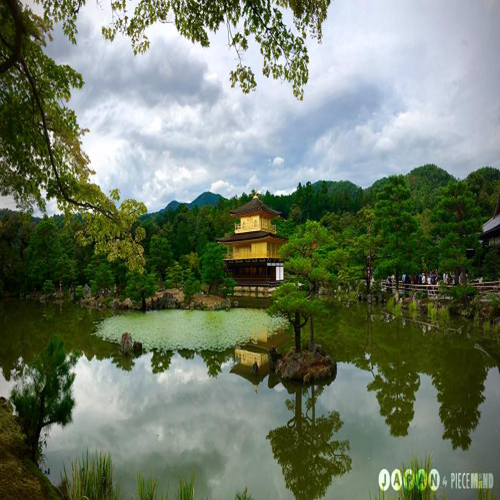

In [0]:
content_image = load_img(content_image_path)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

content_image

    2) Style image

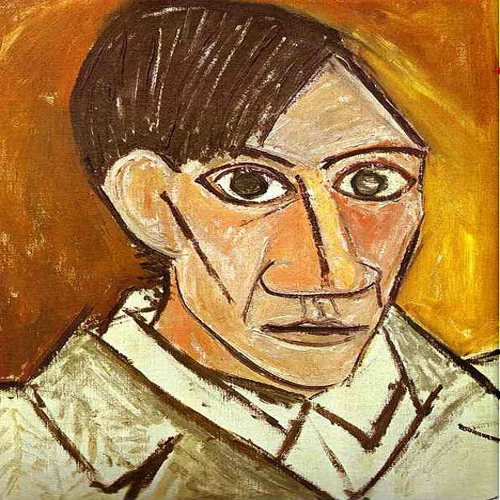

In [0]:
style_image = load_img(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

style_image

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image.

**Data normalization**

Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR. (We defined the values during initialisation)

<!-- and conversion from RGB to BGR -->

In [0]:
# perform reshaping and mean normalization on both images.

content_image_array = np.asarray(content_image, dtype="float32")
content_image_array = np.expand_dims(content_image_array, axis=0)
content_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
content_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
content_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
content_image_array = content_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

**Defining the model**

In this case, we load VGG19, and feed in our input tensor to the model. This will allow us to extract the feature maps (and subsequently the content and style representations) of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer.

In [0]:
content_image = backend.variable(content_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)
model = VGG19(input_tensor=input_tensor, include_top=False)

**Loss functions**

1) Content Loss :- The euclidean distance between the two intermediate layer outputs (layers of content) of content and base input images.

Formally, content loss describes the distance of content from our output image $x$ and our content image, $p$. Let $C_{nn}$ be a pre-trained deep convolutional neural network (in our case, VGG19). Then for any image X, $C_{nn}(X)$ is the network fed by X. And $C^l_{ij}(X)$ describe the respective intermediate feature representation of the network at layer $l$. Then we describe the content distance (loss) formally as:$$L^l_{content}(p, x) = \sum_{i, j} (C^l_{ij}(x) - C^l_{ij}(p))^2$$

We perform backpropagation in the usual way such that we minimize this content loss.

In [0]:
# Defining content loss
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

2) Style Loss:- The Euclidian Distance of the Gram matrices of the the base input image and the style image.

Formally, style loss describes the distance between the style representation (the gram matrices) of the base input image, $x$, and the style image, $a$, the correlation between different filter responses given by the Gram matrix $G^l$, with $G^l_{ij}$ as the inner product between the vectorized feature map $i$ and $j$ in layer $l$.

Minimizing the mean squared distance between the feature correlation map of the style image and the input image is$$L_{style}(a, x) = \sum_{l \in L} \frac{1}{|L|} E_l$$. The contribution of each layer to the total style loss is described by$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$


In [0]:
# Defining style loss
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

# Defining gram matrix
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram



According to Johnson et al., we should select

for a content layer  -> block5_conv2

and for style layers -> block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1

Hence,

In [0]:
# Adding losses due to content loss and style loss
layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block5_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,combination_features)

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

Defining total variation loss

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

Defining the **Evaluator**


In [0]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Generating output image

Iteration 0 completed with loss 128471023616
Iteration 1 completed with loss 31045836800
Iteration 2 completed with loss 23288064000
Iteration 3 completed with loss 18932160512
Iteration 4 completed with loss 16057869312
Iteration 5 completed with loss 14166152192
Iteration 6 completed with loss 12900914176
Iteration 7 completed with loss 11944123392
Iteration 8 completed with loss 11045527552
Iteration 9 completed with loss 10442749952


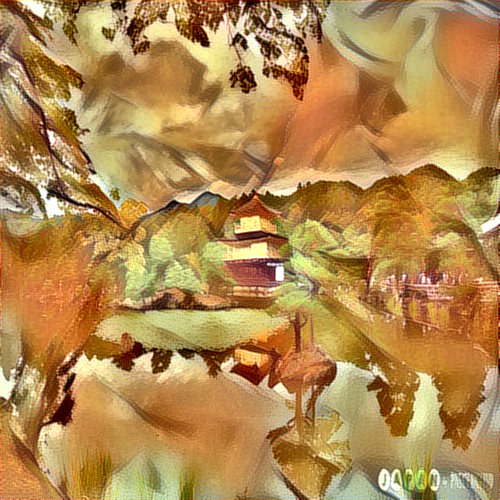

In [0]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")

output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image